#P0. Introducción -PLN

---

En la creación de redes neuronales necesitamos dos tipos de IA, para reconocer patrones o generar nuevos:

*   Las que no tienen memoria, identifica el patrón y ya!...ejemplo las de visión artificial
*   Las de memoria corta (Long Short Term Memory)...PLN
*   Las que requieren mucha memoria (aprenden casi todo...BERT)...PLN y visión artificial.



**Caso de estudio: generación de texto**

---


Cualquier dato que se necesite procesar (sonido, imágenes, texto) primero debe ser convertido en un tensor numérico, un paso llamado “vectorización” (One-hot Encoding y WordEmbedding) de datos (y en nuestro ejemplo previamente las letras deben ser pasadas a valores numéricos 

Para este ejemplo usaremos “*Character level language model*” propuesto por Andrej Karpathy en su artículo "*The Unreasonable Effectiveness of Recurrent Neural Networks*"(y parcialmente basado en su implementado en el tutorial "*Generate text with an RNN*" de la web de TensorFlow:

Consiste en darle a la RNN una palabra y se le pide que modele la distribución de probabilidad del siguiente carácter que le correspondería a la secuencia de caracteres anteriores:

Como ejemplo, supongamos que solo tenemos un vocabulario de cuatro letras posibles [“a”,”h”,”l”,”o”], y queremos entrenar a una RNN en la secuencia de entrenamiento “hola”. Esta secuencia de entrenamiento es, de hecho, una fuente de 3 ejemplos de entrenamiento por separado: La probabilidad de “o” debería ser verosímil dada el contexto de “h”, “l” debería ser verosímil en el contexto de “ho”, y finalmente “a” debería ser también verosímil dado el contexto de “hol”.


---
*   https://unipython.com/generacion-de-textos-con-inteligencia-artificial/
*    https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa (https://www.youtube.com/watch?v=kaQCdv46OBA&ab_channel=JeffHeaton)

#EJEMPLO 1: Prediciendo un texto (cuento los tres cerditos).

In [ ]:
!kill -9 -1 #reiniciando la maquina virtual

##P0. importando librerias

###Librerias genericas

In [ ]:
!pip list

In [ ]:
import requests
import io
import os

import numpy as np
import sys

#librerías para graficar
import matplotlib.pyplot as plt
                 
plt.rcParams['figure.figsize'] = (16, 9)  #ver graficas grandes 
plt.style.use('ggplot')
#guardar las imagenes y tablas en el cuaderno de jupyter
%matplotlib inline 

###librerias para DL (Deep Learning)

In [ ]:
import tensorflow as tf

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
GPU is available


Verificando los recursos de maquina para entrenar:

---
**CUDA (GPU-NVIDIA):**
CUDA es una plataforma de computación paralela y un modelo de programación que hace que el uso de una GPU para la computación de propósito general sea simple y elegante

In [ ]:
print("-------------------------------Espacio DISCO------------------------------")
!df -h
print("-------------------------------Espacio DISCO Disponible------------------------------")
!df -h / | awk '{print $4}'
print("-------------------------------RAM------------------------------")
!cat /proc/meminfo  #cuanta memoria tenemos?
print("-----------------------------PROCESADOR-------------------------")
!cat /proc/cpuinfo  # que procesador tenemos?
print("-----------------------------GPU-------------------------")
!nvidia-smi -L
!nvidia-smi
print("-------------------------------CUDA-----------------------------")
!nvcc -V   # version de CUDA

###Activando la GPU

---
Logra aumentar la velocidad de entrenamiento en un 600% en PLN (RNN) y un 1000% en visión por computadores (CNN)


In [ ]:
tf.device('/GPU:0')# OJO: esto es para que tensorflow utilice la GPU (aumenta la velocidad de entrenamiento en un 600%) 


##P1. Descarga y preprocesado de los datos

In [ ]:
fileUrl     ='https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/2-Deep_Learning/PLN/Datasets/Panel_Txt_Files/cuento_los_tres_cerditos.txt'
fileContent = tf.keras.utils.get_file('Tres_cerditos.txt',fileUrl)
texto       = open(fileContent, 'rb').read().decode(encoding='utf-8')
raw_text    = texto.lower()
print(raw_text)

##P2. pasar el texto a números

---
Sin importan el origen de la informacción (video, sonido, sensor, texto)...siempre debemos convertirlos en datos númericos.


In [ ]:
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
print(chars)
print(char_to_int)

['\n', '\r', ' ', '!', ',', '-', '.', ':', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y', 'z', '¡', '¿', 'á', 'é', 'í', 'ñ', 'ó']
{'\n': 0, '\r': 1, ' ': 2, '!': 3, ',': 4, '-': 5, '.': 6, ':': 7, '?': 8, 'a': 9, 'b': 10, 'c': 11, 'd': 12, 'e': 13, 'f': 14, 'g': 15, 'h': 16, 'i': 17, 'j': 18, 'l': 19, 'm': 20, 'n': 21, 'o': 22, 'p': 23, 'q': 24, 'r': 25, 's': 26, 't': 27, 'u': 28, 'v': 29, 'y': 30, 'z': 31, '¡': 32, '¿': 33, 'á': 34, 'é': 35, 'í': 36, 'ñ': 37, 'ó': 38}


In [ ]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("En total hay %d caracteres, y el diccionario tiene un tamaño de %d caracteres." % (n_chars, n_vocab))

En total hay 2688 caracteres, y el diccionario tiene un tamaño de 39 caracteres.


###P2.1 Dividimos el texto en secuencias:
---
Dividimos el texto en estas secuencias (adrede), convertimos los caracteres a números enteros usando nuestra tabla de búsqueda que preparamos anteriormente



In [ ]:
# preparar el conjunto de datos de los pares de entrada a salida codificados como enteros
seq_length = 50   #largo de las secciones de texto que usaremos para entrenar
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	print("Seq(",i,")=",raw_text[i:i + seq_length],"---->",raw_text[i + seq_length])
	seq_in 	= raw_text[i:i + seq_length]         					#secuencia de entrada
	seq_out = raw_text[i + seq_length]										#siguiente letra despues de la secuencia (la que el va a aprender)
	dataX.append([char_to_int[char] for char in seq_in])  # convertimos cada secuencia en numeros
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print ("Se generaron ",format(n_patterns) ," secuencias texto de un tamaño de ",seq_length," caracteres" )
print("Como se ven los datos de X convertidos a números\n")
print(dataX)
print("\nComo se ven los datos de Y convertidos a números\n")
print(dataY)

##P3. preparar nuestros datos de entrenamiento

---


1.   Primero debemos transformar la lista de secuencias de entrada en la forma [muestras, pasos de tiempo, características] esperada por una red LSTM.
2.   Luego debemos cambiar la escala de los números enteros al rango de 0 a 1 para que los patrones sean más fáciles de aprender mediante la red LSTM que utiliza la función de activación sigmoidea de forma predeterminada.
3.   por ultimo necesitamos convertir los patrones de salida (caracteres individuales convertidos en enteros) en una codificación one hot. Esto es para que podamos configurar la red para predecir la probabilidad de cada uno de los 54 caracteres diferentes en el vocabulario (una representación más fácil)







In [ ]:
#transformar la lista X de secuencias de entrada en la forma [muestras (3091), pasos de tiempo, características]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalizar (cambiar la escala de los números enteros al rango de 0 a 1 )
X = X / float(n_vocab)
# convertir los patrones de salida (caracteres individuales convertidos en enteros) en una codificación one hot.
y = tf.keras.utils.to_categorical(dataY)

##P4.Construcción del modelo RNN

---
definimos nuestro modelo LSTM: 
Aquí definimos una única capa LSTM oculta con 256 unidades de memoria. La red usa deserción con una probabilidad de 20. La capa de salida es una capa densa que usa la función de activación softmax para generar una predicción de probabilidad para cada uno de los 54 caracteres entre 0 y 1.


In [ ]:
# define the LSTM model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2])))    #creamos una capa con 256 unidades de memoria
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))            #Softmax convierte un vector de valores en una distribución de probabilidad para cada uno de los 39
                                                                              #Softmax se utiliza a menudo como la activación para la última capa de una red de clasificación
#utilizamos el algoritmo de optimización de ADAM para la velocidad
model.compile(loss='categorical_crossentropy', optimizer='adam')

###P4.1 Creando chekpoints

---

La red es lenta de entrenar (alrededor de 300 segundos por época) teniendo activa la GPU, ASí que crearemos CHECKPOINTS (puntos de control) para registrar todos los pesos de la red para archivar cada vez que se observe una mejora en la pérdida al final de la época. Usaremos el mejor conjunto de pesos (menor pérdida) para instanciar nuestro modelo generativo en la siguiente sección

In [ ]:
# definimos  una carpeta para guardar los checkpoint
filepath="/content/ckeckpointsRNN/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

###P4.2 entrenando

In [ ]:
history = model.fit(X, y, epochs=1000, batch_size=128, verbose=1,callbacks=callbacks_list)

##P5.Generando texto con una red LSTM


---
Vamos a cargar el ultimo CHECKPOINT de entrenamiento y con el haremos MAGIA!!!


In [ ]:
filename = "/content/ckeckpointsRNN/weights-improvement-976-0.0010.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

###P5.1 mapeo inverso (números a letras)
creamos un mapeo inverso que podamos usar para convertir los números enteros nuevamente en caracteres para que podamos entender las predicciones

In [ ]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

###P5.2 hacer predicciones
La forma más sencilla de utilizar el modelo Keras LSTM para hacer predicciones es comenzar primero con una secuencia semilla como entrada, generar el siguiente carácter y luego actualizar la secuencia semilla para agregar el carácter generado al final y recortar el primer carácter. Este proceso se repite mientras queramos predecir nuevos caracteres (por ejemplo, una secuencia de 1000 caracteres de longitud).

In [ ]:
# elige una semilla al azar
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Semilla:")
print ("\"" + " ".join([int_to_char[value] for value in pattern])+"\"")
# generación de 10000 caracteres
for i in range(1000):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")

##P6.Mejorando la red (una LSTM más grande)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(256))                                                                #agregaremos una segunda capa. 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam')
#cambiamos el nombre de archivo de los pesos con puntos de control para que 
#podamos distinguir entre los pesos de esta red 
filepath="/content/checkpointsRNNv2/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"

###P6.1 mejoramos el entrenamiento

---
aumentamos las epoch y disminuiremos el tamaño del lote de 128 a 64 para darle a la red más oportunidades de actualizarse y aprender.


In [ ]:
#los tiempos de entrenamiento aumentaran al doble que en la versión anterior
model.fit(X, y, epochs=100, batch_size=32, callbacks=callbacks_list)

###P6.2 haciendo predicciones

In [ ]:
# elige una semilla al azar
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Semilla:")
print ("\"" + " ".join([int_to_char[value] for value in pattern])+"\"")
# generación de caracteres
for i in range(1000):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")

Semilla:
 
 
 a s í   c u a n d"
o el lobo cayó por la chimenea el agua estaba hirviendo y se pegó tal quemazo que salió gritando de la casa y no volvió a comer cerditos en una larga temporada.al la casa de su hermano mayor.

el lobo estaba cada vez más hambriento así que sopló y sopló con todas sus fuerzas, pero esta vez no tenía nada que hacer porque la casa no se movía ni siquiera un poco. dentro los cerditos le oyeron, y para darle su merecido llenaron la chimenea de leña y pusieron al fuego un gran caldero con agua.

así cuando el lobo cayó por la chimenea el agua estaba hirviendo y se pegó tal quemazo que salió gritando de la casa y no volvió a comer cerditos en una larga temporada.al la casa de su hermano mayor.

el lobo estaba cada vez más hambriento así que sopló y sopló con todas sus fuerzas, pero esta vez no tenía nada que hacer porque la casa no se movía ni siquiera un poco. dentro los cerditos le oyeron, y para darle su merecido llenaron la chimenea de leña y pusieron al f

##P7. exportar modelo RNN

In [ ]:
!pip install h5py

In [ ]:
from keras.models import model_from_json
import os
# Serializamos el modelo en forma JSON
model_json = model.to_json()
with open("modelRNN_cuentos.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/modeloRNN_cuentosPesos.hdf5")
model.save('modelRNN_cuentos_v_h5.h5')
print("modelo salvado en disco")

modelo salvado en disco


###P7.1 cargando un modelo

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
import keras
import numpy
new_model = keras.models.load_model('/content/modelRNN_cuentos_v_h5.h5')

In [ ]:
chars = sorted(list(set("comiendo una manzana")))
char_to_int = dict((c, i) for i, c in enumerate(chars))
n_chars = len(raw_text)
n_vocab = len(chars)
print("En total hay %d caracteres, y el diccionario tiene un tamaño de %d caracteres." % (n_chars, n_vocab))
pattern = dataX[5]
print(pattern)

En total hay 2688 caracteres, y el diccionario tiene un tamaño de 11 caracteres.
[2, 28, 21, 9, 2, 29, 13, 31, 2, 27, 25, 13, 26, 2, 16, 13, 25, 20, 9, 21, 22, 26, 2, 11, 13, 25, 12, 17, 27, 22, 26, 2, 24, 28, 13, 2, 29, 17, 29, 36, 9, 21, 2, 13, 21, 2, 13, 19, 2, 10]


In [ ]:
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Semilla:")
print ("\"" + " ".join([int_to_char[value] for value in pattern])+"\"")
# generación de caracteres
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = new_model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")

Semilla:
"h i m e n e a   d e   l e ñ a   y   p u s i e r o n   a l   f u e g o   u n   g r a n   c a l d e r"
   co  q au q s su  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s pu  q s p



---



---



#Ejemplo 2: generar texto de cuentos, usando Keras

##Instalando librerias CUDA

In [ ]:
#!pip list
!nvcc --version  #Version de CUDA en la maquina virtual

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


##P0. importar librerias

In [ ]:
#OPCIONAL 
!pip install tensorflow-gpu #(opcional sobre para trabajar con EQUIPOS LOCALES..google colab ya la trae instalada)

In [64]:
import tensorflow as tf
import timeit               #para medir tiempos
import datetime
import numpy as np
import pandas as pd 
import os
import time
import sys
#----librerias para normalización de textos
import re
from unicodedata import normalize

###P0.1 Uso de GPU para entrenar en tensorflow

---
https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa


In [65]:
print("Tensorflow Version: ", tf.__version__)
print("Dispositivos disponibles para entrenar: ", tf.config.list_physical_devices())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Encontrada la GPU: {}'.format(device_name))

Tensorflow Version:  2.8.0
Dispositivos disponibles para entrenar:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Encontrada la GPU: /device:GPU:0


###P0.2 probando rendimiento de CPU vs GPU

In [ ]:
def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)   

In [ ]:
cpu()  #ejecutamos entrenamiento con CPU
gpu()  #ejecutamos entrenamiento con GPU
# Run the op several times.
print('TIEMPO (seg) para entrenar una red convolucional de 32x7x7x3 filtros sobre un randomico de 100x100x100x3 imagenes '
      '(batch x height x width x channel). suma de 10 epochs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

TIEMPO (seg) para entrenar una red convolucional de 32x7x7x3 filtros sobre un randomico de 100x100x100x3 imagenes (batch x height x width x channel). suma de 10 epochs.
CPU (s):
3.7553839289994357
GPU (s):
0.04974163599945314
GPU speedup over CPU: 75x


###P0.3 Dejando activo la GPU

In [66]:
#tf.device('/gpu:0') #activando la CPU
tf.device('/device:GPU:0') #activando la GPU 

##P0. Descarga y preprocesado de los datos

In [ ]:
#urlText='https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/2-Deep_Learning/PLN/Datasets/Panel_Txt_Files/LasMinasDelReySalomon.txt'
urlText='https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/2-Deep_Learning/PLN/Datasets/Panel_Txt_Files/ElGatoConBotas.txt'
fileDL= tf.keras.utils.get_file('ElGatoConBotas.txt',urlText)
texto = open(fileDL, 'rb').read().decode(encoding='utf-8')
print(texto)

###P0.1 limpiar/normalizar el texto

---
*   pasar todo a minusculas
*   convertir tildes a vocales sin tilde
*   eliminar caracteres especiales (*#!()%=
*   eliminar saltos de linea y tab (identación)

In [68]:
#pasa todo a minuscula
texto     = texto.lower()
#reemplazar tildes por letras similares sin tildes
transfor  = dict.fromkeys(map(ord, u'\u0301\u0308'), None)
texto     = normalize('NFKC', normalize('NFKD', texto).translate(transfor))
#quitar saltos de linea
texto      = texto.strip()
texto      = re.sub('\r|\n', ' ',texto)
#quitar espacios dobles
texto      = re.sub(' +', ' ', texto)
#quitando caracteres especiales
texto = re.sub(r"[^a-zA-Z0-9]+"," ",texto)
print(texto)

el gato con botas un molinero dejo como unica herencia a sus tres hijos su molino su burro y su gato el reparto fue bien simple ya que no se necesito llamar ni al abogado ni al notario pues habrian consumido por el cobro todo el pobre patrimonio el mayor recibio el molino el segundo se quedo con el burro y al menor le toco solo el gato este se lamentaba de su misera herencia mis hermanos decia podran ganarse la vida convenientemente trabajando juntos lo que es yo despues de comerme a mi gato y de hacerme un manguito con su piel me morire de hambre el gato que escuchaba estas palabras pero se hacia el desentendido le dijo en tono serio y pausado no debes afligirte mi se or solo tienes que proporcionarme una bolsa y un par de botas para andar por entre los matorrales y veras que tu herencia no es tan pobre como piensas aunque el amo del gato no abrigaba sobre esto grandes ilusiones aunque le habia visto dar tantas muestras de agilidad para cazar ratas y ratones colgarse de los pies escon

##P1. entendiendo el texto

In [69]:
print('el texto tiene longitud de:{} caracteres'. format(len(texto)))
vocab = sorted(set(texto))
print('el texto esta compuesto de estos :{} caracteres'. format(len(vocab)))
print(vocab)

el texto tiene longitud de:7884 caracteres
el texto esta compuesto de estos :25 caracteres
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z']


##P2. pasar el texto a números

---
Las redes neuronales solo procesan valores numéricos, no letras, por tanto tenemos que traducir los caracteres a representación numérica. Para ello crearemos dos “tablas de traducción”: una de caracteres a números y otra de números a caracteres

In [ ]:
char2idx = {u:i for i, u in enumerate(vocab)} # asignamos un número a cada vocablo
idx2char = np.array(vocab)
#-----------revisando las conversiones

#for char,_ in zip(char2idx, range(len(vocab))):
    #print(' {:4s}: {:3d},'.format(repr(char),char2idx[char]))

#pasamos todo el texto a números
texto_como_entero= np.array([char2idx[c] for c in texto])
print('texto: {}'.format(repr(texto[:100])))
print('{}'.format(repr(texto_como_entero[:100])))

In [26]:
print(idx2char)   # vocablos
print(char2idx)   # numero de vocablos

[' ' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'x' 'y' 'z']
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'x': 22, 'y': 23, 'z': 24}


###P2.1 exportar vocablos y matriz de numerica

---

exporta en un CSV para usarlo cuando se cargue el modelo en otra instancia

In [71]:
rows=[]
columns=['num','vocab']
for i, voc in enumerate(vocab):
  #print(i,'-->', voc)
  rows.append([i,voc])
df= pd.DataFrame(columns=['num','vocab'],data=rows)
df.head(10)
df.to_csv('data_vocab.csv',index=False)

##P3. preparar los datos para ser usados en la RNN

In [72]:
char_dataset= tf.data.Dataset.from_tensor_slices(texto_como_entero)
#cantidad de secuencia de caracteres
secu_length=50
#creamos secuencias de maximo 100 caractereres
secuencias= char_dataset.batch(secu_length+1, drop_remainder=True)
for item in secuencias.take(10):
  print(repr(''.join(idx2char[item.numpy()])))

'el gato con botas un molinero dejo como unica heren'
'cia a sus tres hijos su molino su burro y su gato e'
'l reparto fue bien simple ya que no se necesito lla'
'mar ni al abogado ni al notario pues habrian consum'
'ido por el cobro todo el pobre patrimonio el mayor '
'recibio el molino el segundo se quedo con el burro '
'y al menor le toco solo el gato este se lamentaba d'
'e su misera herencia mis hermanos decia podran gana'
'rse la vida convenientemente trabajando juntos lo q'
'ue es yo despues de comerme a mi gato y de hacerme '


###P3.1 separar los datos en agrupamientos (batches)

In [73]:
#funcion para obtener el conjunto de datos de trainning
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text= chunk[1:]
  return input_text, target_text

dataset  = secuencias.map(split_input_target)
#el dataset contiene un conjunto de parejas de secuencia de texto
#(con la representación numérica de los caracteres), donde el 
#primer componente de la pareja contiene un paquete con una secuencia 
#de 100 caracteres del texto original y la segunda su correspondiente salida, 
#también de 100 caracteres. )
for input_example, target_example in dataset.take(1):
  print('input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print('Target data: ', repr(''.join(idx2char[target_example.numpy()])))

input data:  'el gato con botas un molinero dejo como unica here'
Target data:  'l gato con botas un molinero dejo como unica heren'


In [74]:
#imprimimos el tensor del dataset
print(dataset)
#Hyper-Parametros para entrenamiento  de una rede neuronal 
#   -los datos se agrupan en batch
BATCH_SIZE= 64
#    -Tamaño de memoria disponible 
BUFFER_SIZE=10000
dataset= dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print (dataset)
#En el tensor dataset disponemos los datos de entrenamiento
#con agrupamienttos (batches) compuestos de 64 parejas de secuencias 
#de 100 integers de 64 bits que representan el carácter correspondiente 
#en el vocabulario.

<MapDataset element_spec=(TensorSpec(shape=(50,), dtype=tf.int64, name=None), TensorSpec(shape=(50,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int64, name=None), TensorSpec(shape=(64, 50), dtype=tf.int64, name=None))>


##P4.Construcción del modelo RNN

---
Para construir el modelo usaremos tf.keras.Sequential. Usaremos una versión mínima de RNN, que contenga solo una capa LSTM y 3 capas.
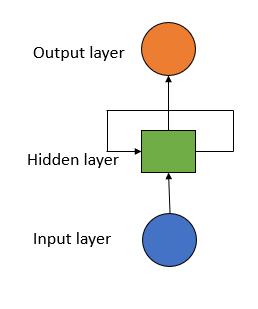

In [105]:
#como es un problema de clasificación estándar 
#para el que debemos definir la función de Lossy el optimizador.
def lossPLN(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

def create_model(vocab_size, embedding_dim, rnn_units, batch_size):
  #creando el modelo cuya entrada es la cantidad de vocablos que se encontraron en el texto
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                         return_sequences=True,
                         stateful=True,
                         recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)                               
  ])
  #En cuanto al optimizador usaremos tf.keras.optimizers.Adam 
  #usaremos para el calculo de perdida SparseCategoricalCrossentropy con el parametro from_logits=True
  #este atributo informa a la función de pérdida que los valores de salida generados por el modelo no están normalizados, 
  #es decir, logits. En otras palabras, no se les ha aplicado la función softmax para producir una distribución de probabilidad.
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model
vocab_size= len(vocab)
#dimensiones de los vectores que tendrá la capa.
embedding_dim= 256
#cantidad de neuronas
rnn_units=1024
#creamos nuestra red neuronal RNN
model=create_model(vocab_size   =vocab_size,
                  embedding_dim =embedding_dim,
                  rnn_units     =rnn_units,
                  batch_size    =BATCH_SIZE)
#summary()para visualizar la estructura del modelo
model.summary()
#resultados=  -La capa LSTM consta más de 5 millones de parametros)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (64, None, 256)           6400      
                                                                 
 lstm_24 (LSTM)              (64, None, 1024)          5246976   
                                                                 
 dense_24 (Dense)            (64, None, 25)            25625     
                                                                 
Total params: 5,279,001
Trainable params: 5,279,001
Non-trainable params: 0
_________________________________________________________________


###P4.1 Creando chekpoints

---
una técnica de tolerancia de fallos para procesos cuyo tiempo de ejecución es muy largo. La idea es guardar una instantánea del estado del sistema periódicamente para recuperar desde ese punto la ejecución en caso de fallo del sistema.

---
los crearemos en google drive para mejorar la capacidad de reentrenamiento de la red


In [106]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [107]:
checkpoint_dir='/content/gdrive/MyDrive/IA/PLN/ckeckpoint_RNN'
checkpoint_prefix= os.path.join(checkpoint_dir,"cp_{epoch:04d}.ckpt")

cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                               monitor='loss',
                                               verbose=1,
                                               save_weights_only=True,
                                               save_best_only=True,
                                               mode='auto')


###P4.2 entrenando

####P4.2a entrenando para usar chekpoints


---

*   https://keras.io/api/callbacks/model_checkpoint/
*   https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

In [108]:
EPOCHS=300
history=model.fit(dataset, 
                  epochs=EPOCHS, 
                  verbose=1,
                  callbacks=[cp_callback])

2/2 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9620
Epoch 200: loss did not improve from 0.14048
2/2 [==============================] - 0s 134ms/step - loss: 0.1441 - accuracy: 0.9620
Epoch 201/300
2/2 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9614
Epoch 201: loss did not improve from 0.14048
2/2 [==============================] - 0s 135ms/step - loss: 0.1470 - accuracy: 0.9614
Epoch 202/300
2/2 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9623
Epoch 202: loss did not improve from 0.14048
2/2 [==============================] - 0s 132ms/step - loss: 0.1489 - accuracy: 0.9623
Epoch 203/300
2/2 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9631
Epoch 203: loss did not improve from 0.14048
2/2 [==============================] - 0s 133ms/step - loss: 0.1461 - accuracy: 0.9631
Epoch 204/300
2/2 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9647
Epoch 204: 


#####4.2a-1 entrenando desde un checkpoint

---
Desde la carpeta que optamos guardar los checkpoints

*   el archivo .data es el archivo que contiene nuestras variables de entrenamiento y vamos a ir tras él.
*   el archivo checkpoint, simplemente mantiene un registro de los últimos archivos de punto de control guardados




In [78]:
#creamos un modelo con iguales caracteristicas al 1° modelo
model=create_model(vocab_size   =vocab_size,
                  embedding_dim =embedding_dim,
                  rnn_units     =rnn_units,
                  batch_size    =BATCH_SIZE)

#buscamos el ultimo checkpoint de entrenamiento
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/content/gdrive/MyDrive/IA/PLN/ckeckpoint_RNN/cp_0297.ckpt


In [ ]:
# cargamos los pesos al nuevo modelo (estos valores tienes una variación de un 10%)
model.load_weights(latest)
# continuamos el entrenamiento desde el checkpoint en que quedamos
history2=model.fit(dataset, 
                    epochs=300, 
                    verbose=1,
                    callbacks=[cp_callback])              


####P4.2b entrenando con tensorboard (opcional)

#####Activando TENSORBOARD 

---
(DASHBOARD para ver el proceso de entrenamiento)

In [ ]:
%load_ext tensorboard  #cargando la extensión de tensorboard
!rm -rf /content/drive/MyDrive/IA/PLN/checkpoints_rnn/  # limpiamos la carpeta de cualquier log de entrenamiento previo (en google drive)

In [ ]:
#definimos una carpeta dentro de google drive
log_dir = "/content/drive/MyDrive/IA/PLN/checkpoints_rnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#####Fit

In [ ]:
model.fit(dataset, 
          epochs=500, 
          callbacks=[tensorboard_callback])

#####tensorboard - resultado fit

In [ ]:
!tensorboard dev upload \
  --logdir /content/drive/MyDrive/IA/PLN/checkpoints_rnn \
  --name "RNN gato con botas" \
  --description "RNN gato con botas" \
  --one_shot

##P5. Generando texto nuevo usando la RNN

In [109]:
#creamos un modelo tomando como base el ultimo checkpoint
model = create_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1,None]))

In [ ]:
print(input_eval)

In [110]:
#funcion para generar texto
def generate_text(model, start_string):
  #definimos cuantos tensores/cantidad de texto generaremos
  num_generate=500
  #convertimos el texto en números
  input_eval=[char2idx[s] for s in start_string]
  input_eval= tf.expand_dims (input_eval,0)
  text_generated = []

  temperature = 0.2  #(0.0 a  1) entre más alta la temperatura más creatividad al modelo, pero tambien más errores ortograficos.
  model.reset_states() #bucle para generar caracteres, mediante predicciones
  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval= tf.expand_dims([predicted_id],0)
    text_generated.append (idx2char[predicted_id])
  
  return (start_string+ ''.join(text_generated))


###P5.1 generando texto 

In [111]:
print(generate_text(model, start_string=u"te odio"))

te odio pado con las riquezas del se or marques de carabas al iga del rey y ese mismo dia se caso con la princesa el gato se asusto tanto al ver a un leon delante de la forma del mas peque o animalillo por ejemplo que puedes por ejemplo transformarte en leon en elefieso que eso me parece imposible imposible repuso al ver que su proyecto empezaba a resultar se adel reparto fue bien simple ya que no se necesito llas vera majestad es una tierra que no deja de producia a sus tres hijos su molino su burro y


##P6.exportando modelo

---
Guardamos y Serializamos el Modelo (con esto ya podemos vender nuestro modelo de predicción de texto según lo aprendido por nuestra RNN).


In [113]:
from keras.models import model_from_json
import os
dir_export= '/content/gdrive/MyDrive/IA/PLN/Modelos'
dir_export= '/content'
#dir_export= os.path.join(dir_drive)
# Serializamos el modelo en forma JSON
model_json = model.to_json()
with open(os.path.join(dir_export,'elGatoConBotas.json'), 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(dir_export,'elGatoConBotas.hdf5'))
model.save(os.path.join(dir_export,'elGatoConBotas.h5'))
print("modelo salvado en Drive de google")

modelo salvado en Drive de google


##P7.Cargando un modelo serializado

###P7.1a descargamos el modelo usando wget (no esta descargando completo el archivo)

In [ ]:
!wget https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/2-Deep_Learning/PLN/recurrent_network_RNN/Modelos/ElGatoConBotas/elGatoConBotas.h5?raw=true \
      -O elGatoConBotas.h5

###P7.1b descargamos el modelo usando PYRIND & URLLIB (OPCIONAL)

In [ ]:
!pip install pyprind

In [90]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurrido" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()

import urllib.request
url_github_Model='https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/2-Deep_Learning/PLN/recurrent_network_RNN/Modelos/ElGatoConBotas/elGatoConBotas.h5?raw=true'
urllib.request.urlretrieve(url_github_Model,
                           'elGatoConBotas.h5', 
                           reporthook)

100% | 60 MB | 4.50 MB/s | 13 segundos transcurrido

('elGatoConBotas.h5', <http.client.HTTPMessage at 0x7fd06987d650>)

###P7.2 instanciamos el modelo descargado

In [114]:
new_model = tf.keras.models.load_model('/content/elGatoConBotas.h5')

In [ ]:
df2 = pd.read_csv("https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/2-Deep_Learning/PLN/recurrent_network_RNN/Modelos/LasMinasDelReySalomon/data_vocab.csv")
df2.head()

,num,vocab
0,0,
1,1,0
2,2,1
3,3,2
4,4,3


In [ ]:
char2idx = df2[["num"]].to_numpy()
idx2char = df2[["vocab"]].to_numpy()

In [ ]:
print(idx2char)   # vocablos
print(char2idx)   # numero de vocablos

In [117]:
#funcion para generar texto
def generate_text(model, start_string):
  #definimos cuantos tensores/cantidad de texto generaremos
  num_generate=500
  #convertimos el texto en números
  input_eval  = [char2idx[s] for s in start_string]
  input_eval  = tf.expand_dims (input_eval,0)
  text_generated = []

  temperature = 0.5  #(0.0 a  1) entre más alta la temperatura más creatividad al modelo, pero tambien más errores ortograficos.
  model.reset_states() #bucle para generar caracteres, mediante predicciones
  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval= tf.expand_dims([predicted_id],0)
    text_generated.append (idx2char[predicted_id])
  
  return (start_string+ ''.join(text_generated))


In [118]:
print(generate_text(new_model, start_string=u"los fantasmas de "))

los fantasmas de carabas hermoso que eso me parece imposible imposible repuso se or marques que seas mi yerno el marques haciendo que el rey iria a pasear a orillas del rio con suen busca de sus mas bellas vestiduras para el se or marques de carabas el rey le hizo mil atenciones y se or marques que seas mi yerno el marques haciendo que el rey iria a pasear a orillas del rio con sue es yo despues de comerme a mi gato y de hacerme el interior por favor el marques ofrecio la mano a los cuales no se habian atrevido 
